This is the minimal implementation of this solution of Petfinder Pawpularity, The number of folds, epochs and other models selection are reduced due to longer time training, but the overall strategy is demonstrated.
### Overview
The 2nd-place Pawpularity solution used a two-stage hybrid ensemble. In the first stage, they trained many different image models such as Swin, ViT, ConvNeXt, and CaiT using various image sizes and loss functions (BCE, MSE, Poisson, CE) to maximize diversity. In the second stage, they combined the out-of-fold predictions from those models with metadata features (including information merged from the older PetFinder competition using image hashing) and trained a LightGBM regressor . The final weights for combining models were refined with a least-squares regression, minimizing RMSE on validation data. 
### Strength
This approach worked well because of its model variety and feature engineering of new inputs from the previous competition as well as image aspect. 
### Differences to our model
The authors used a broader range of architectures and metadata integration techniques compared to our approach.

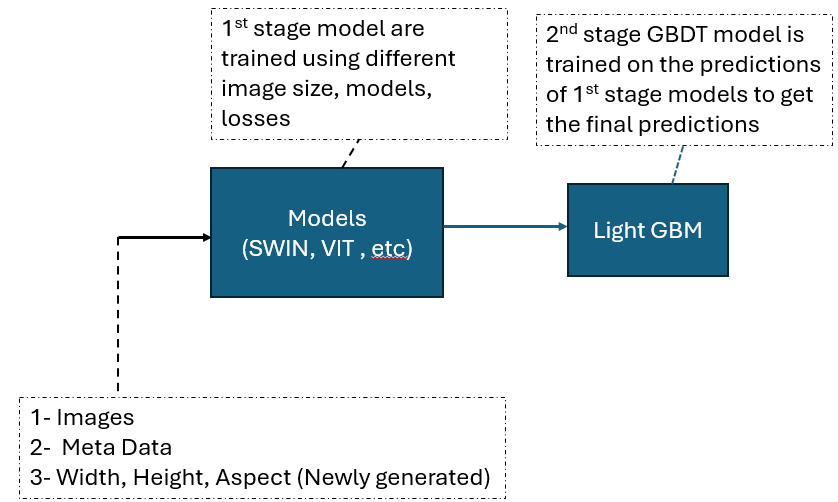


In [36]:




import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import timm
import albumentations as A
from tqdm.auto import tqdm
import os
import gc
import joblib
import pickle
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import imagehash
import glob
import warnings
warnings.filterwarnings('ignore')
import math



BASE_PATH = "inputs/"
# --- Metadata Column Names ---
METADATA_COLS = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


# --- 1. Data Loading, Metadata Processing, and Stratified Folds ---
train = pd.read_csv(BASE_PATH + 'train.csv') 
train['file'] = train['Id'].apply(lambda x: f'{BASE_PATH}train/{x}.jpg')

# Standardize the Pawpularity target (0-1) and extract metadata features
train['target_normalized'] = train['Pawpularity'] / 100.0

IMAGE_COLS = ["width","height","aspect"]

METADATA_DIM = len(METADATA_COLS+IMAGE_COLS) # Should be 15
train['file'] = train['Id'].apply(lambda x: f'{BASE_PATH}train/{x}.jpg')


# --- Add width, height, aspect columns ---
def add_image_shape_features(df):
    heights, widths = [], []

    print("Extracting image shapes...")
    for path in tqdm(df['file'].values):
        try:
            with Image.open(path) as img:
                heights.append(img.height)
                widths.append(img.width)
        except:
            heights.append(np.nan)
            widths.append(np.nan)

    df['height'] = heights
    df['width'] = widths
    df['aspect'] = df['height'] / df['width']

    

    # --- Compute mean/std  ---
    h_mean, h_std = df['height'].mean(), df['height'].std()
    w_mean, w_std = df['width'].mean(), df['width'].std()

    print(f'Calculated height mean={h_mean:.2f}, std={h_std:.2f}')
    print(f'Calculated width mean={w_mean:.2f}, std={w_std:.2f}')

    # --- Standardize height and width ---
    df['height'] = (df['height'] - h_mean) / h_std
    df['width'] = (df['width'] - w_mean) / w_std

    return df

train = add_image_shape_features(train)
train['metadata'] = train[METADATA_COLS+IMAGE_COLS].values.tolist() # Store metadata as a list/array per row
# --- Create bins using Sturges' rule ---
# k = 1 + 3.322 * log10(n)
n = len(train)
k = int(1 + 3.322 * math.log10(n))
train['bin'] = pd.cut(train['Pawpularity'], bins=k, labels=False)

print(f"Sturges' rule: n={n}, bins={k}")

# --- 5-Fold Stratified Split ---
train['fold'] = -1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for i, (_, val_idx) in enumerate(skf.split(train, train['bin'])):
    train.loc[val_idx, 'fold'] = i
train['fold'] = train['fold'].astype(int)

OOF_SAVE_DIR = "top2Hash"
os.makedirs(OOF_SAVE_DIR, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Extracting image shapes...


  0%|          | 0/9912 [00:00<?, ?it/s]

Calculated height mean=904.28, std=156.91
Calculated width mean=804.43, std=270.21
Sturges' rule: n=9912, bins=14


In [37]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Blur,Pawpularity,file,target_normalized,height,width,aspect,metadata,bin,fold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,0,63,inputs/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0.63,-1.174489,-1.478196,1.777778,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",8,4
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,0,42,inputs/train/0009c66b9439883ba2750fb825e1d7db.jpg,0.42,-0.830334,0.842205,0.750000,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,3
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,0,28,inputs/train/0013fd999caf9a3efe1352ca1b0d937e.jpg,0.28,0.355090,-0.312445,1.333333,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",3,4
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,0,15,inputs/train/0018df346ac9c1d8413cfcc888ca8246.jpg,0.15,-1.174489,-1.478196,1.777778,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,0,72,inputs/train/001dc955e10590d3ca4673f034feeef2.jpg,0.72,0.355090,-0.978588,1.777778,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",10,0


In [ ]:

# PART 1: DATASET AND MODEL DEFINITIONS


print("\n" + "="*80)
print("PART 1: DEFINING DATASET AND MODELS")
print("="*80)

class PetDataset(Dataset):
    def __init__(self, image_paths, targets, metadata, transform=None, target_dtype=torch.float):
        self.image_paths = image_paths
        self.targets = targets 
        self.metadata = metadata
        self.transform = transform
        self.target_dtype = target_dtype

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = np.array(image)
        if self.transform:
            image = self.transform(image=image)["image"]
        
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float),
            'target': torch.tensor(self.targets[idx], dtype=self.target_dtype)
        }


def get_transforms(img_size=224, is_train=True):
    if is_train:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
        ])
    else:
        return A.Compose([A.Resize(img_size, img_size)])


class PetModel(nn.Module):
    def __init__(self, model_name, num_classes, metadata_dim, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        
        # Image backbone
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0) 
        self.feature_dim = self.model.num_features
        
        # Final head with metadata
        total_input_dim = self.feature_dim + metadata_dim
        
        self.final_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(total_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x_img, x_meta):
        img_features = self.model(x_img)
        combined_features = torch.cat([img_features, x_meta], dim=1)
        out = self.final_head(combined_features)
        
        if self.num_classes == 1:
            return out.squeeze(-1)
        return out




PART 1: DEFINING DATASET AND MODELS


In [ ]:


# PART 2: TRAINING FUNCTION


def train_dl_model(model_name, train_df, loss_type, n_epochs, batch_size, 
                   img_size, lr, save_dir):
    
    os.makedirs(save_dir, exist_ok=True)
    n_folds = 5
    oof_preds = np.zeros(len(train_df), dtype=float)
    max_patience = 3

    if loss_type == 'BCE':
        num_classes = 1
        criterion = nn.BCEWithLogitsLoss()
        target_dtype = torch.float
    else:
        raise ValueError("Only BCE supported in this simplified version")

    for fold in range(n_folds):
        print(f"\n{'='*70}")
        print(f"Model: {model_name} | Fold {fold+1}/{n_folds}")
        print(f"{'='*70}")
        
        tr_ind = train_df['fold'] != fold
        val_ind = train_df['fold'] == fold
        
        tr_paths = train_df.loc[tr_ind, 'file'].values
        val_paths = train_df.loc[val_ind, 'file'].values
        val_targets_original = train_df.loc[val_ind, 'Pawpularity'].values 
        
        tr_metadata = np.stack(train_df.loc[tr_ind, 'metadata'].values)
        val_metadata = np.stack(train_df.loc[val_ind, 'metadata'].values)
        
        # Normalize to [0, 1] for BCE
        tr_targets = train_df.loc[tr_ind, 'Pawpularity'].values / 100.0
        val_targets_normalized = train_df.loc[val_ind, 'Pawpularity'].values / 100.0
        
        train_dataset = PetDataset(
            tr_paths, tr_targets, tr_metadata,
            transform=get_transforms(img_size, is_train=True),
            target_dtype=target_dtype
        )
        val_dataset = PetDataset(
            val_paths, val_targets_normalized, val_metadata,
            transform=get_transforms(img_size, is_train=False),
            target_dtype=target_dtype
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                  num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False, 
                               num_workers=0, pin_memory=True)

        model = PetModel(model_name, num_classes=num_classes, 
                        metadata_dim=METADATA_DIM, pretrained=True).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=1)

        best_val_rmse = float('inf')
        best_val_preds = None
        patience = 0

        for epoch in range(n_epochs):
            # Training
            model.train()
            train_loss = 0.0
            train_count = 0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
                imgs = batch['image'].to(device)
                metas = batch['metadata'].to(device) 
                tgts = batch['target'].to(device) 
                
                optimizer.zero_grad()
                logits = model(imgs, metas)
                loss = criterion(logits, tgts)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item() * len(imgs)
                train_count += len(imgs)
            
            avg_train_loss = train_loss / train_count
            scheduler.step()

            # Validation
            model.eval()
            val_preds = []
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Valid]"):
                    imgs = batch['image'].to(device)
                    metas = batch['metadata'].to(device) 
                    logits = model(imgs, metas)
                    scaled = torch.sigmoid(logits) * 100.0
                    val_preds.extend(scaled.cpu().numpy())

            val_preds = np.clip(np.array(val_preds), 1, 100)
            val_rmse = np.sqrt(np.mean((val_targets_original - val_preds) ** 2))
            
            print(f"   Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Val RMSE: {val_rmse:.4f}", end='')

            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_val_preds = val_preds.copy()
                torch.save(model.state_dict(), 
                          os.path.join(save_dir, f"{model_name}_fold{fold}.pth"))
                patience = 0
                print(" -> **BEST**")
            else:
                patience += 1
                print(f" | Patience: {patience}/{max_patience}")
                
                if patience >= max_patience:
                    print(f"   Early stopping triggered")
                    break

        oof_preds[val_ind.values] = best_val_preds
        print(f"Fold {fold+1} Complete | Best RMSE: {best_val_rmse:.4f}")
        
        del model, optimizer, scheduler, train_dataset, val_dataset, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    overall_rmse = np.sqrt(np.mean((train_df['Pawpularity'].values - oof_preds) ** 2))
    print(f"\n{'='*70}")
    print(f"{model_name} - Overall OOF RMSE: {overall_rmse:.4f}")
    print(f"{'='*70}")
    
    np.save(os.path.join(save_dir, f"oof_{model_name}.npy"), oof_preds)
    return oof_preds, overall_rmse




In [ ]:

# PART 3: TRAIN STAGE 1 MODELS (2 MODELS)


print("\n" + "="*80)
print("PART 3: TRAINING STAGE 1 DL MODELS")
print("="*80)

stage1_models_config = [
   # Model 1: Simple Regression (BCE  Loss)
    {"name": "efficientnet_b0", "size": 224, "loss_type": "BCE", "lr": 1e-4, "epochs": 3, "batch_size": 26},
    {"name": "convnext_tiny", "size": 224, "loss_type": "BCE", "lr": 5e-5, "epochs": 3, "batch_size": 26},
]

stage1_oofs = {}

for cfg in stage1_models_config:
    print(f"\n{'#'*80}")
    print(f"Training: {cfg['name']}")
    print(f"{'#'*80}")
    
    oof, rmse = train_dl_model(
        model_name=cfg["name"],
        train_df=train,
        loss_type="BCE",
        n_epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        img_size=cfg["size"],
        lr=cfg["lr"],
        save_dir=OOF_SAVE_DIR
    )
    
    stage1_oofs[cfg['name']] = oof

print("\n" + "="*80)
print("STAGE 1 COMPLETE!")
print("="*80)




PART 3: TRAINING STAGE 1 DL MODELS

################################################################################
Training: efficientnet_b0
################################################################################

Model: efficientnet_b0 | Fold 1/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6559 | Val RMSE: 18.7465 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6380 | Val RMSE: 19.3189 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6227 | Val RMSE: 19.5310 | Patience: 2/3
Fold 1 Complete | Best RMSE: 18.7465

Model: efficientnet_b0 | Fold 2/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6553 | Val RMSE: 18.7774 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6367 | Val RMSE: 19.0271 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6208 | Val RMSE: 19.4870 | Patience: 2/3
Fold 2 Complete | Best RMSE: 18.7774

Model: efficientnet_b0 | Fold 3/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6552 | Val RMSE: 18.5248 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6377 | Val RMSE: 18.9750 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6218 | Val RMSE: 18.9532 | Patience: 2/3
Fold 3 Complete | Best RMSE: 18.5248

Model: efficientnet_b0 | Fold 4/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6552 | Val RMSE: 18.8393 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6385 | Val RMSE: 18.7096 -> **BEST**


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6226 | Val RMSE: 18.9618 | Patience: 1/3
Fold 4 Complete | Best RMSE: 18.7096

Model: efficientnet_b0 | Fold 5/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6539 | Val RMSE: 19.0245 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6365 | Val RMSE: 19.3644 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6209 | Val RMSE: 19.8411 | Patience: 2/3
Fold 5 Complete | Best RMSE: 19.0245

efficientnet_b0 - Overall OOF RMSE: 18.7573

################################################################################
Training: convnext_tiny
################################################################################

Model: convnext_tiny | Fold 1/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6676 | Val RMSE: 20.7367 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6655 | Val RMSE: 20.7544 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6651 | Val RMSE: 20.6994 -> **BEST**
Fold 1 Complete | Best RMSE: 20.6994

Model: convnext_tiny | Fold 2/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6683 | Val RMSE: 20.6018 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6653 | Val RMSE: 20.6424 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6650 | Val RMSE: 20.5642 -> **BEST**
Fold 2 Complete | Best RMSE: 20.5642

Model: convnext_tiny | Fold 3/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6624 | Val RMSE: 20.5298 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6490 | Val RMSE: 18.4238 -> **BEST**


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6341 | Val RMSE: 18.3637 -> **BEST**
Fold 3 Complete | Best RMSE: 18.3637

Model: convnext_tiny | Fold 4/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6672 | Val RMSE: 20.6014 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6655 | Val RMSE: 20.7611 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6591 | Val RMSE: 19.0296 -> **BEST**
Fold 4 Complete | Best RMSE: 19.0296

Model: convnext_tiny | Fold 5/5


Epoch 1/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 1/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 1/3 | Train Loss: 0.6682 | Val RMSE: 20.5827 -> **BEST**


Epoch 2/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 2/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 2/3 | Train Loss: 0.6652 | Val RMSE: 20.6130 | Patience: 1/3


Epoch 3/3 [Train]:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch 3/3 [Valid]:   0%|          | 0/39 [00:00<?, ?it/s]

   Epoch 3/3 | Train Loss: 0.6650 | Val RMSE: 20.5637 -> **BEST**
Fold 5 Complete | Best RMSE: 20.5637

convnext_tiny - Overall OOF RMSE: 19.8676

STAGE 1 COMPLETE!


In [ ]:


# PART 4: HASH AND MERGE WITH PREVIOUS COMPETITION


print("\n" + "="*80)
print("PART 4: HASHING AND MERGING WITH PREVIOUS COMPETITION")
print("="*80)

# Hash current competition images
print("Hashing current competition images...")
train['hash'] = None
for idx, row in tqdm(train.iterrows(), total=len(train)):
    try:
        img = Image.open(row['file']).convert('RGB')
        train.at[idx, 'hash'] = str(imagehash.average_hash(img))
    except Exception as e:
        print(f"Error hashing {row['file']}: {e}")

# Load and hash previous competition
print("\nLoading previous competition data...")
prev_train = pd.read_csv(f'{BASE_PATH}pet_adopt/train/train.csv')
prev_image_dir = f'{BASE_PATH}pet_adopt/train_images/'

print("Hashing previous competition images ...")
prev_hashes = []
for idx, row in tqdm(prev_train.iterrows(), total=len(prev_train)):
    pet_id = row['PetID']
    img_path = f"{prev_image_dir}/{pet_id}-1.jpg"
    
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img_hash = str(imagehash.average_hash(img))
            prev_hashes.append({
                'PetID': pet_id,
                'hash': img_hash,
                'path': img_path
            })
        except Exception as e:
            print(f"Error hashing {img_path}: {e}")

prev_hashes_df = pd.DataFrame(prev_hashes)

# Merge previous metadata
prev_hashes_df = prev_hashes_df.merge(prev_train, on='PetID', how='left')

print(f"Previous competition: {len(prev_hashes_df)} images hashed")

# Merge with current competition by hash
print("\nMerging competitions by image hash...")
df = train.merge(prev_hashes_df, on='hash', how='left', suffixes=('', '_prev'))

n_matched = df['PetID'].notna().sum()
print(f"Matched images: {n_matched} ({n_matched/len(df)*100:.1f}%)")




PART 4: HASHING AND MERGING WITH PREVIOUS COMPETITION
Hashing current competition images...


  0%|          | 0/9912 [00:00<?, ?it/s]


Loading previous competition data...
Hashing previous competition images ...


  0%|          | 0/14993 [00:00<?, ?it/s]

Previous competition: 2020 images hashed

Merging competitions by image hash...
Matched images: 218 (2.2%)


In [47]:
print("Before merge:", train['Id'].head())
print("After merge:", df['Id'].head())

Before merge: 0    0007de18844b0dbbb5e1f607da0606e0
1    0009c66b9439883ba2750fb825e1d7db
2    0013fd999caf9a3efe1352ca1b0d937e
3    0018df346ac9c1d8413cfcc888ca8246
4    001dc955e10590d3ca4673f034feeef2
Name: Id, dtype: object
After merge: 0    0007de18844b0dbbb5e1f607da0606e0
1    0009c66b9439883ba2750fb825e1d7db
2    0013fd999caf9a3efe1352ca1b0d937e
3    0018df346ac9c1d8413cfcc888ca8246
4    001dc955e10590d3ca4673f034feeef2
Name: Id, dtype: object


In [43]:
train

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Pawpularity,file,target_normalized,height,width,aspect,metadata,bin,fold,hash
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,63,inputs/train/0007de18844b0dbbb5e1f607da0606e0.jpg,0.63,-1.174489,-1.478196,1.777778,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",8,4,fff0f0e7c3c1072f
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,42,inputs/train/0009c66b9439883ba2750fb825e1d7db.jpg,0.42,-0.830334,0.842205,0.750000,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,3,a1e0317130383d0f
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,28,inputs/train/0013fd999caf9a3efe1352ca1b0d937e.jpg,0.28,0.355090,-0.312445,1.333333,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",3,4,fff3c3e0f0c08080
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,15,inputs/train/0018df346ac9c1d8413cfcc888ca8246.jpg,0.15,-1.174489,-1.478196,1.777778,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0,ff7ff840c200c3e0
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,72,inputs/train/001dc955e10590d3ca4673f034feeef2.jpg,0.72,0.355090,-0.978588,1.777778,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",10,0,e0c04007bb097f7f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,15,inputs/train/ffbfa0383c34dc513c95560d6e1fdb57.jpg,0.15,0.355090,-0.068192,1.221374,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,2,fff9c10307070f1f
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,70,inputs/train/ffcc8532d76436fc79e50eb2e5238e45.jpg,0.70,0.355090,-0.312445,1.333333,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9,3,ffe7c7e3e0e0f0d3
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,20,inputs/train/ffdf2e8673a1da6fb80342fa3b119a20.jpg,0.20,-0.052798,-0.401264,1.287356,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2,3,c08021207ef6feb8
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,20,inputs/train/fff19e2ce11718548fa1c5d039a5192a.jpg,0.20,0.355090,-0.312445,1.333333,"[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",2,1,7f3fc1a1363e0000


In [ ]:


# PART 5: FEATURE ENGINEERING


print("\n" + "="*80)
print("PART 5: FEATURE ENGINEERING")
print("="*80)

# Add Stage 1 OOF predictions to dataframe
df['pred1'] = stage1_oofs[stage1_models_config[0]['name']]
df['pred2'] = stage1_oofs[stage1_models_config[1]['name']]

# Check for any NaN in predictions
print(f"NaN in pred1: {df['pred1'].isna().sum()}")
print(f"NaN in pred2: {df['pred2'].isna().sum()}")

# Find optimal weights using least squares

valid_mask = df['pred1'].notna() & df['pred2'].notna()
coef = np.linalg.lstsq(
    df.loc[valid_mask, ['pred1', 'pred2']].values, 
    df.loc[valid_mask, 'Pawpularity'].values / 100,
    rcond=None
)[0]

print(f"Ensemble coefficients: pred1={coef[0]:.4f}, pred2={coef[1]:.4f}")

#  weighted ensemble
df['pred'] = np.dot(df[['pred1', 'pred2']].values, coef)

# Clip predictions to valid range [0.01, 1.0]
df['pred'] = df['pred'].clip(0.01, 1.0)

# Stage 1 ensemble RMSE
stage1_rmse = np.sqrt(np.mean((df['Pawpularity'].values - df['pred'].values * 100) ** 2))
print(f"Stage 1 Ensemble RMSE: {stage1_rmse:.4f}")

# Text features from previous competition
df['len_desc'] = df['Description'].fillna('').map(len)
df['len_name'] = df['Name'].fillna('').map(len)

# Binary flag for whether image has previous competition data
df['has_prev_data'] = df['PetID'].notna().astype(int)

print(f"\nImages with previous data: {df['has_prev_data'].sum()}/{len(df)}")

# Create feature list
COL_FEATURES = [
    # Current competition
    'Blur', 'Eyes',
    
    # Stage 1 ensemble
    'pred',
    
    # Binary flag
    'has_prev_data',
    
    # Previous competition (selected features)
    'Age', 'Breed1', 'Gender', 'Color3', 'FurLength',
    'Vaccinated', 'Quantity', 'Fee', 'State', 'PhotoAmt', 'AdoptionSpeed'
]

# Check for missing values BEFORE filling
print("\nMissing values before filling:")
for col in COL_FEATURES:
    if col in df.columns:
        n_missing = df[col].isna().sum()
        if n_missing > 0:
            print(f"  {col}: {n_missing} ({n_missing/len(df)*100:.1f}%)")

# Fill missing values with -1 (for images not in previous competition)
for col in COL_FEATURES:
    if col in df.columns:
        df[col] = df[col].fillna(-1)
    else:
        print(f"WARNING: {col} not found in dataframe!")
        df[col] = -1  # Create column with -1 if not exists

# Verify no missing values remain
print("\nMissing values after filling:")
n_missing_total = df[COL_FEATURES].isna().sum().sum()
if n_missing_total > 0:
    print(f"  WARNING: Still have {n_missing_total} missing values!")
    print(df[COL_FEATURES].isna().sum())
else:
    print("  All missing values handled ")

# Check data types
print("\nData types:")
for col in COL_FEATURES:
    print(f"  {col}: {df[col].dtype}")

# Convert all to float for LGBM
for col in COL_FEATURES:
    df[col] = df[col].astype(float)

print(f"\nTotal features for Stage 2: {len(COL_FEATURES)}")




PART 5: FEATURE ENGINEERING
NaN in pred1: 0
NaN in pred2: 0
Ensemble coefficients: pred1=0.0079, pred2=0.0019
Stage 1 Ensemble RMSE: 18.6362

Images with previous data: 218/9912

Missing values before filling:
  Age: 9694 (97.8%)
  Breed1: 9694 (97.8%)
  Gender: 9694 (97.8%)
  Color3: 9694 (97.8%)
  FurLength: 9694 (97.8%)
  Vaccinated: 9694 (97.8%)
  Quantity: 9694 (97.8%)
  Fee: 9694 (97.8%)
  State: 9694 (97.8%)
  PhotoAmt: 9694 (97.8%)
  AdoptionSpeed: 9694 (97.8%)

Missing values after filling:
  All missing values handled ✓

Data types:
  Blur: int64
  Eyes: int64
  pred: float64
  has_prev_data: int64
  Age: float64
  Breed1: float64
  Gender: float64
  Color3: float64
  FurLength: float64
  Vaccinated: float64
  Quantity: float64
  Fee: float64
  State: float64
  PhotoAmt: float64
  AdoptionSpeed: float64

Total features for Stage 2: 15


In [ ]:


# PART 6: TRAIN STAGE 2 LGBM



print("PART 6: TRAINING STAGE 2 LGBM")


# FINAL DATA VALIDATION BEFORE TRAINING
print("\nFinal data validation before LGBM training:")
print(f"  Total samples: {len(df)}")
print(f"  Features shape: {df[COL_FEATURES].shape}")

# Check for any remaining issues
X_check = df[COL_FEATURES].values
y_check = df['Pawpularity'].values



def rmse_metric(preds, train_data):
    labels = train_data.get_label()
    loss = np.sqrt(((labels - preds.clip(0.01, 1)) ** 2).mean()) * 100
    return 'rmse', loss, False


lgb_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.2,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'num_iterations': 10000,
    'seed': 114,
    'metric': 'None',
    'learning_rate': 0.05,
    'lambda_l2': 1,
    'min_child_samples': 140,
    'num_leaves': 7,
    'feature_fraction': 0.7,
    'min_gain_to_split': 0.02,
}


def train_fold_lgb(fold, param):
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values / 100
    
    # Check for any NaN or inf values
    if np.isnan(X_train.values).any() or np.isinf(X_train.values).any():
        print("WARNING: NaN or Inf in training data!")
        X_train = X_train.fillna(-1).replace([np.inf, -np.inf], -1)
    
    if np.isnan(X_valid.values).any() or np.isinf(X_valid.values).any():
        print("WARNING: NaN or Inf in validation data!")
        X_valid = X_valid.fillna(-1).replace([np.inf, -np.inf], -1)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(
        param,
        train_data,
        valid_sets=valid_data,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100)
        ],
        feval=rmse_metric
    )
    
    val_preds = model.predict(X_valid, num_iteration=model.best_iteration)
    return model, val_preds, y_valid





PART 6: TRAINING STAGE 2 LGBM

Final data validation before LGBM training:
  Total samples: 9912
  Features shape: (9912, 15)


In [59]:
# Store all validation predictions and labels
all_val_preds = []
all_val_labels = []

for fold in range(5):
   
    print(f"Training Fold {fold+1}/5")
    
    model, val_preds, val_labels = train_fold_lgb(fold, lgb_params)
    
    # Append fold predictions and labels
    all_val_preds.append(val_preds)
    all_val_labels.append(val_labels)

# Concatenate all folds
all_val_preds = np.concatenate(all_val_preds)
all_val_labels = np.concatenate(all_val_labels)

# Compute CV RMSE over all validation samples
cv_rmse = np.sqrt(((all_val_preds - all_val_labels) ** 2).mean()) * 100

print(f"Stage 2 LGBM CV RMSE (all folds combined): {cv_rmse:.4f}")


Training Fold 1/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 18.7843
[200]	valid_0's rmse: 18.7991
Early stopping, best iteration is:
[138]	valid_0's rmse: 18.7775
Training Fold 2/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 18.7194
Early stopping, best iteration is:
[88]	valid_0's rmse: 18.7186
Training Fold 3/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 18.2373
[200]	valid_0's rmse: 18.2434
Early stopping, best iteration is:
[113]	valid_0's rmse: 18.2341
Training Fold 4/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 18.5756
Early stopping, best iteration is:
[54]	valid_0's rmse: 18.5002
Training Fold 5/5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 19.1112
Early stopping, best iteration is:
[74]	valid_0's rmse: 19.1071
Stage 2 LGBM CV RMSE (all folds combined): 18.6722
